# CIFAR-10 Dataset Analysis and Modelling

## The notebook is split into broadly five sections:

* Library and data preparation
* Clustering
* Algorithmic modelling (Decision Trees, Random Forests etc.)
* Neural Networks
* Results and discussion

Note if running in Colab Pro - A100 or L4 GPU is sufficient to run in a suitable time, but you'll need some GPU power to run the Neural Networks section.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
import seaborn as sns
from sklearn.metrics import recall_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import warnings
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

%matplotlib inline
warnings.filterwarnings('ignore')
!pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.3 MB/s eta 0:00:00
time: 250 µs (started: 2025-08-26 19:28:23 +00:00)


In [2]:
from numpy.random import seed
seed(42)  #added this so results are repeatable

time: 407 µs (started: 2025-08-26 19:28:23 +00:00)


# A) Exploratory Data Analysis and Preprocessing


### 1. Dataset Overview

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
time: 16.1 s (started: 2025-08-26 19:28:23 +00:00)


In [4]:
print(X_train[:5])

[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 79  82  64]
   [ 68  70  55]
   [ 67  69

So pixels are in 0-255 format RGB

In [5]:
print(y_train[:5])

[[6]
 [9]
 [9]
 [4]
 [1]]
time: 472 µs (started: 2025-08-26 19:28:39 +00:00)


Labels are in single number format - let's look at the distribution

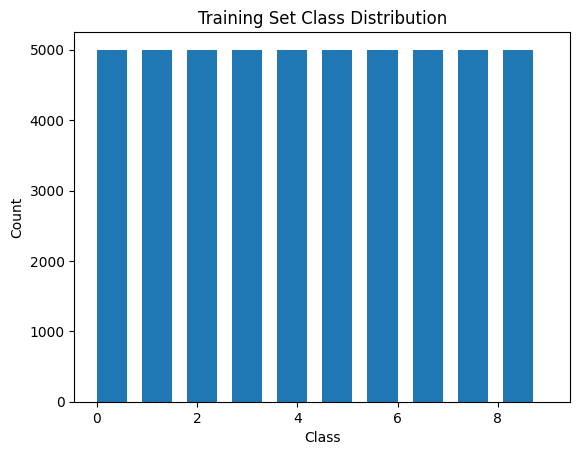

time: 176 ms (started: 2025-08-26 19:28:39 +00:00)


In [6]:
plt.hist(y_train.flatten(), width = 0.6)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Training Set Class Distribution")
plt.show()

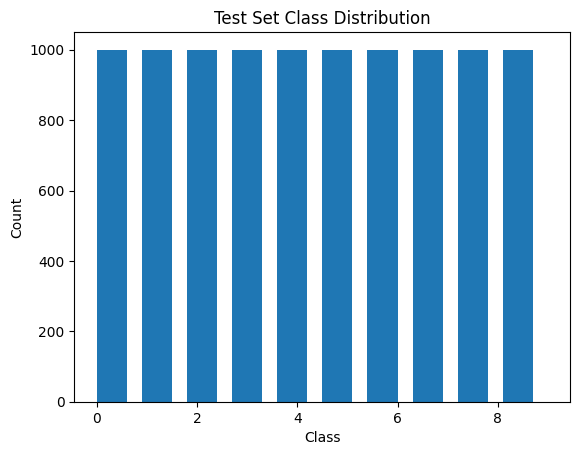

time: 105 ms (started: 2025-08-26 19:28:39 +00:00)


In [7]:
plt.hist(y_test.flatten(), width = 0.6)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Test Set Class Distribution")
plt.show()

So balanced dataset with 5,000 entries for each class in the training dataset and 1,000 entries each in test

## Visualization

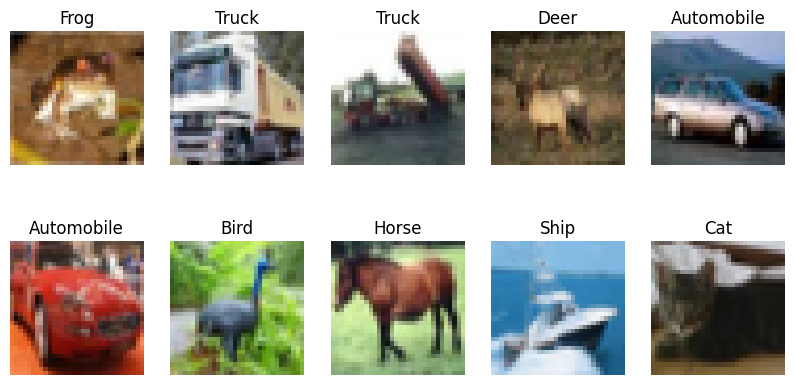

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
time: 292 ms (started: 2025-08-26 19:28:39 +00:00)


In [8]:
# Visualize some sample images with labels
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.show()

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

## Pre-processing

In [9]:
ntrainsamples = X_train.shape[0]
ntestsamples = X_test.shape[0]

X_train_2d = np.reshape(X_train, (ntrainsamples, -1))
X_test_2d = np.reshape(X_test, (ntestsamples, -1))

scaler_train = preprocessing.StandardScaler().fit_transform(X_train_2d)
scaler_test = preprocessing.StandardScaler().fit_transform(X_test_2d)

time: 3.18 s (started: 2025-08-26 19:28:40 +00:00)


Create greyscale versions of the images

In [10]:
# (Greyscale weightings from (OpenCV, 2019))

def greyscale(image):
  row_list = []
  row_count = len(image[0])
  column_count = len(image[1])
  for row in range(row_count-1):
    column_list = []
    for column in range(column_count-1):
      pixel = image[row][column]
      greyimg = 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]
      column_list.append(greyimg)
    row_list.append(column_list)
  return row_list

time: 728 µs (started: 2025-08-26 19:28:43 +00:00)


(np.float64(-0.5), np.float64(30.5), np.float64(30.5), np.float64(-0.5))

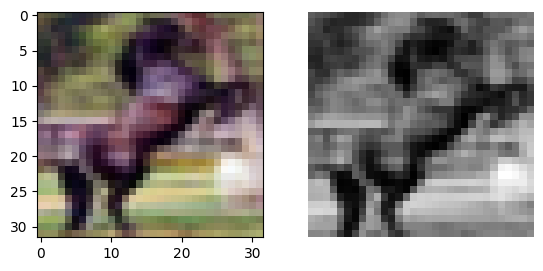

time: 118 ms (started: 2025-08-26 19:28:43 +00:00)


In [11]:
orig_img = X_train[84]

grey = greyscale(orig_img)
plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.subplot(1, 2, 2)
plt.imshow(grey, cmap = 'gray')
plt.axis('off')

In [12]:
X_train_grey = []
X_test_grey = []
for image in X_train:
  X_train_grey.append(greyscale(image))
for image in X_test:
  X_test_grey.append(greyscale(image))

time: 5min 36s (started: 2025-08-26 19:28:43 +00:00)


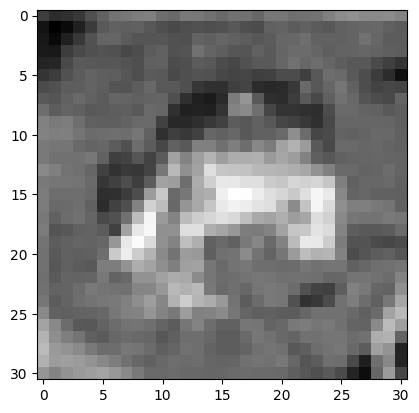

time: 117 ms (started: 2025-08-26 19:34:19 +00:00)


In [13]:
plt.imshow(X_train_grey[0], cmap = 'gray')

In [14]:
X_train_2d_grey = np.reshape(X_train_grey, (ntrainsamples, -1))
X_test_2d_grey = np.reshape(X_test_grey, (ntestsamples, -1))

scaler_train_grey = preprocessing.StandardScaler().fit_transform(X_train_2d_grey)
scaler_test_grey = preprocessing.StandardScaler().fit_transform(X_test_2d_grey)

time: 4.32 s (started: 2025-08-26 19:34:19 +00:00)


# B) Clustering

In [15]:
pca = PCA(n_components=2)

pca.fit(scaler_train)
pca.fit(scaler_test)

X_train_pca = pca.transform(scaler_train)
X_test_pca = pca.transform(scaler_test)

time: 5.15 s (started: 2025-08-26 19:34:24 +00:00)


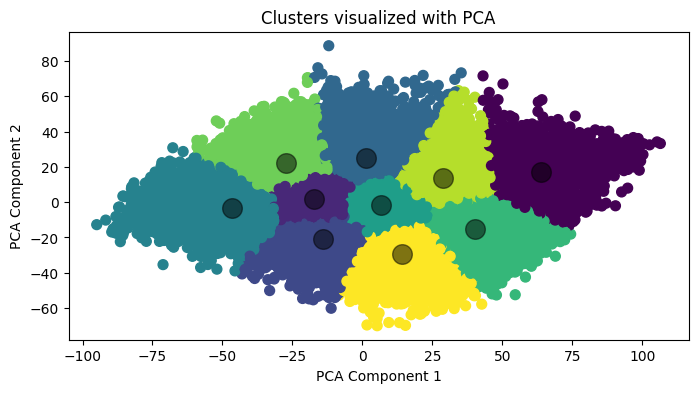

time: 1.33 s (started: 2025-08-26 19:34:29 +00:00)


In [16]:
n = 10
k_means = KMeans(n_clusters=n)
k_means.fit(X_train_pca)
y_kmeans = k_means.predict(X_train_pca)

plt.figure(figsize=(8, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = k_means.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [17]:
kmeans_acc = accuracy_score(y_train, y_kmeans)
print(f"Accuracy: {kmeans_acc}")

Accuracy: 0.12736
time: 4.91 ms (started: 2025-08-26 19:34:30 +00:00)


Next I'm going to create a function to display a confusion matrix as we'll re-use for each of the models (matrix from Tunstall, 2022), as well as a function to pull the correct guesses (i.e. the diagonal).

In [18]:
def plot_confusion_matrix(y_preds, y_true, labels, model_name):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize = (6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
  disp.plot(cmap = "Blues", ax = ax, colorbar = False)
  plt.xticks(rotation = 45)
  title = f"{model_name} Confusion Matrix"
  ax.set_title(title)
  plt.show()

time: 632 µs (started: 2025-08-26 19:34:30 +00:00)


In [19]:
diagonals = [] # this is going to be used to collect the diagonals from each CM
def get_diagonal(y_preds, y_true, labels, model_name):
  cm = confusion_matrix(y_true, y_preds)
  correct_guesses = cm.diagonal()
  row = {"Model":model_name}
  for i in range(len(labels)):
    row[labels[i]] = correct_guesses[i]
  diagonals.append(row)

time: 572 µs (started: 2025-08-26 19:34:30 +00:00)


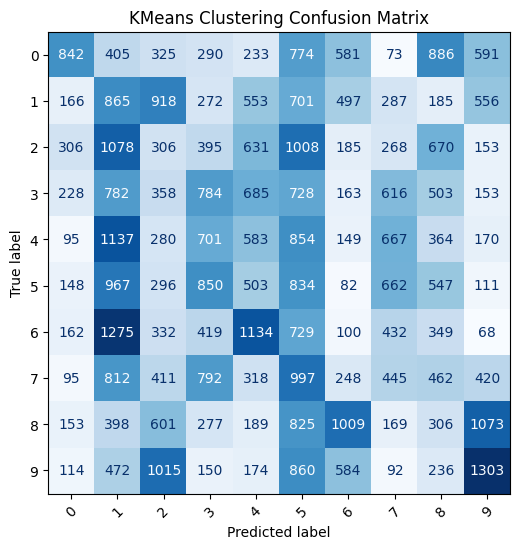

time: 251 ms (started: 2025-08-26 19:34:30 +00:00)


In [20]:
cluster_labels=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(y_kmeans, y_train, cluster_labels, "KMeans Clustering")

Now lets look at some of items contained in the groupings:

There are 2309 members in cluster 0
[ 20  41  48  49  79 108 191 203 266 315]


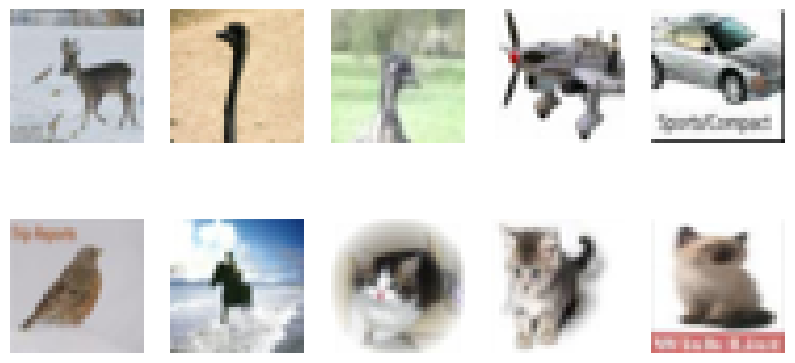

There are 8191 members in cluster 1
[14 21 23 24 32 37 39 45 46 47]


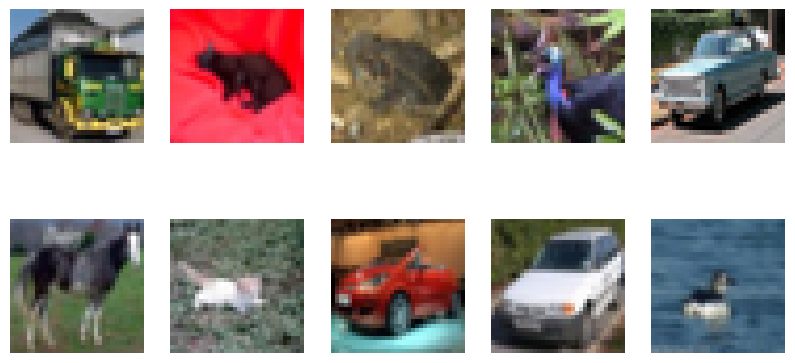

There are 4842 members in cluster 2
[ 4  5  9 26 35 40 44 51 59 60]


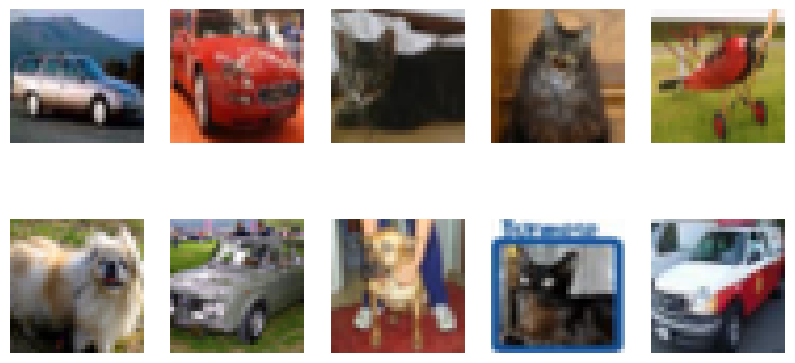

There are 4930 members in cluster 3
[  7  19  33  87 133 141 149 151 182 197]


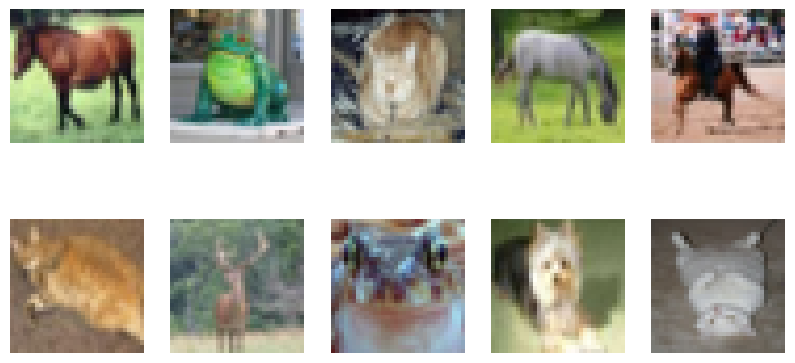

There are 5003 members in cluster 4
[ 3 10 22 27 54 57 68 73 85 88]


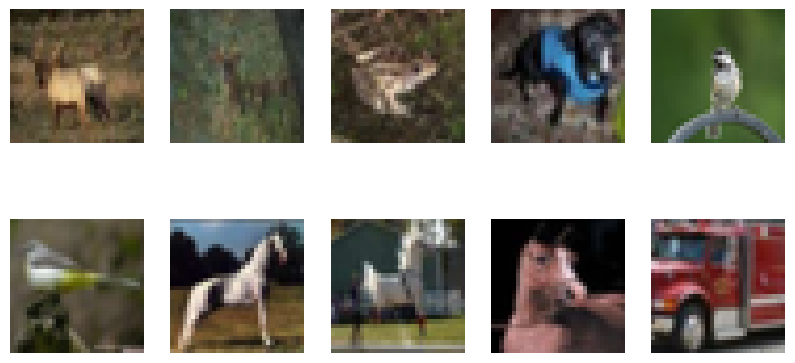

There are 8310 members in cluster 5
[ 1  6 18 25 28 30 34 42 61 62]


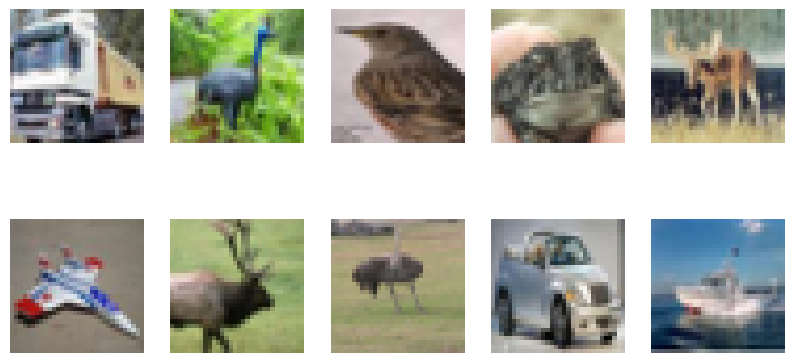

There are 3598 members in cluster 6
[ 11  29  53  55  67  76 100 105 115 118]


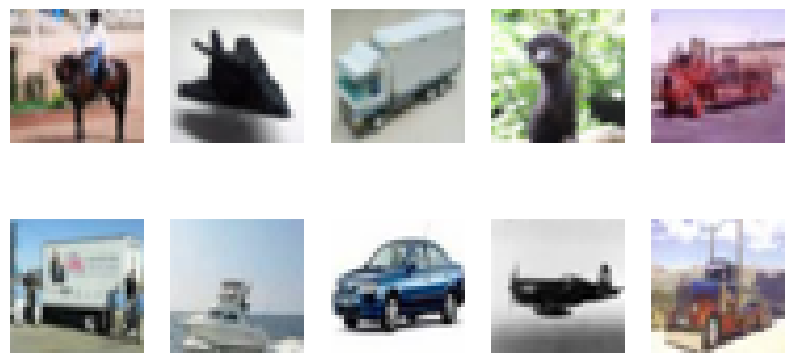

There are 3711 members in cluster 7
[  0  13  17  52  56  84  86 142 145 157]


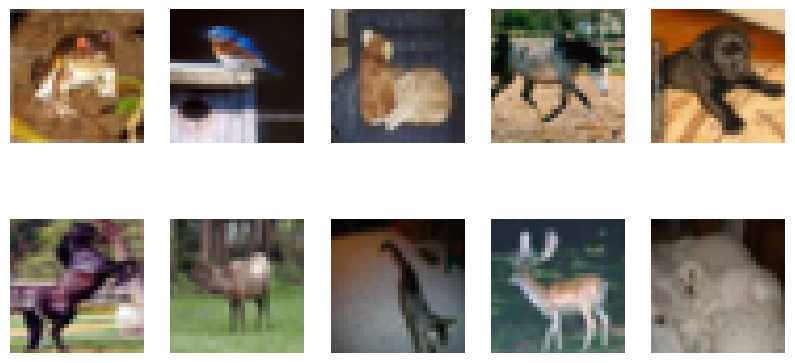

There are 4508 members in cluster 8
[  8  36  43  92  95 114 120 123 125 129]


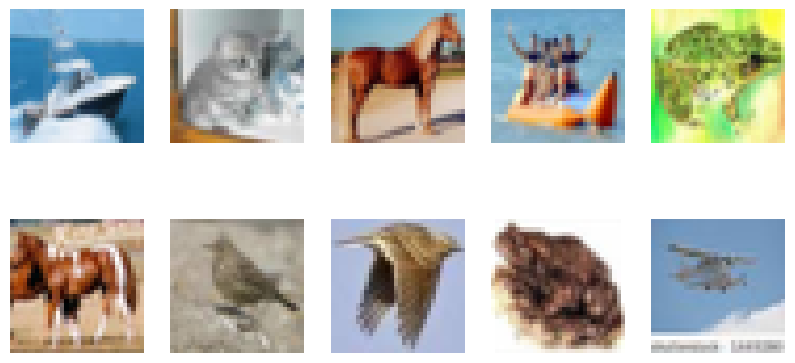

There are 4598 members in cluster 9
[  2  12  15  16  31  38  94 109 122 126]


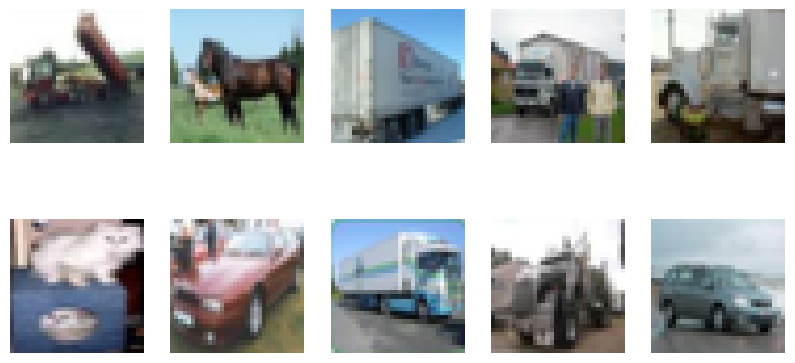

time: 1.16 s (started: 2025-08-26 19:34:31 +00:00)


In [21]:
for cluster in np.arange(n):

    cluster_member_indices = np.where(y_kmeans == cluster)[0]
    print("There are %s members in cluster %s" % (len(cluster_member_indices), cluster))

    first_ten = cluster_member_indices[:10]
    print(first_ten)
    #pick a random member
    plt.figure(figsize=(10, 5))
    count = 0
    for x in first_ten:
      plt.subplot(2, 5, count+1)
      plt.imshow(X_train[x])
      plt.axis('off')
      count += 1
    plt.show()

So this reflects what we're seeing in the metrics - although some clusters are better than others (cluster 9 has 5 horses for example) some are terrible (cluster 7 has a mix of 7 classes!).  There's also quite a difference in the numbers for each cluster - cluster 0 has 2,309 members, and cluster 1 8,191.


# C) Classification models

## Decision Tree

(general layout for this section from Navlani, 2023)

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(scaler_train,y_train)

#Predict the response for test dataset
y_pred_tree = clf.predict(scaler_test)

# Model Accuracy, how often is the classifier correct?
tree_acc = accuracy_score(y_test, y_pred_tree)
print("Accuracy:", tree_acc)

Accuracy: 0.269
time: 4min 7s (started: 2025-08-26 19:34:32 +00:00)


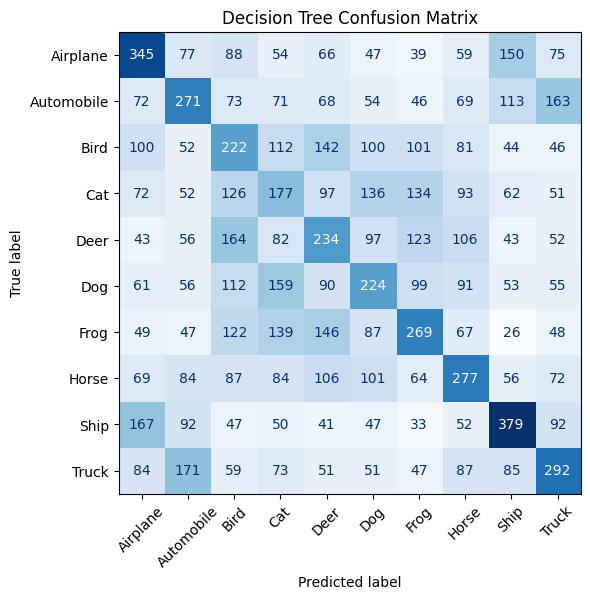

time: 244 ms (started: 2025-08-26 19:38:39 +00:00)


In [23]:
plot_confusion_matrix(y_pred_tree, y_test, class_names, "Decision Tree")

In [24]:
get_diagonal(y_pred_tree, y_test, class_names, "Decision Tree")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}]
time: 2.5 ms (started: 2025-08-26 19:38:39 +00:00)


Accuracy is fairly low at 27%, and this is reflected in the confusion matrix where the strongest score in the test set is 380 / 1000 for Ships.  Some of the categories like Dog, Frog and Bird are showing high levels of confusion with the predictions spread across a number of other categories.

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Create Decision Tree classifer object
clf_grey = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf_grey = clf_grey.fit(scaler_train_grey,y_train)

#Predict the response for test dataset
y_pred_tree_grey = clf_grey.predict(scaler_test_grey)

# Model Accuracy, how often is the classifier correct?
tree_acc_grey = accuracy_score(y_test, y_pred_tree_grey)
print("Accuracy:", tree_acc_grey)

Accuracy: 0.2281
time: 2min 29s (started: 2025-08-26 19:38:39 +00:00)


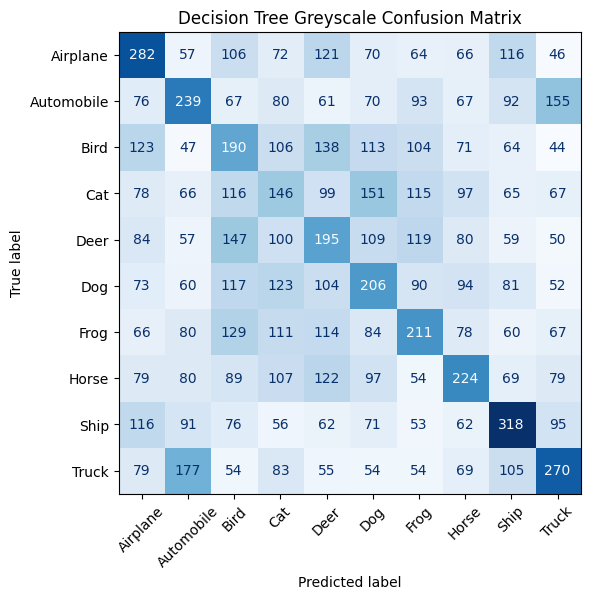

time: 250 ms (started: 2025-08-26 19:41:09 +00:00)


In [26]:
plot_confusion_matrix(y_pred_tree_grey, y_test, class_names, "Decision Tree Greyscale")

In [27]:
get_diagonal(y_pred_tree_grey, y_test, class_names, "Decision Tree Greyscale")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}]
time: 2.81 ms (started: 2025-08-26 19:41:10 +00:00)


Greyscale hasn't improved the accuracy, even at an individual category level.

## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifer object
rf = RandomForestClassifier()

# Train Decision Tree Classifer
rf = rf.fit(scaler_train, y_train)

#Predict the response for test dataset
y_pred_rf = rf.predict(scaler_test)

# Model Accuracy, how often is the classifier correct?
rf_acc = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", rf_acc)

Accuracy: 0.4688
time: 5min 12s (started: 2025-08-26 19:41:10 +00:00)


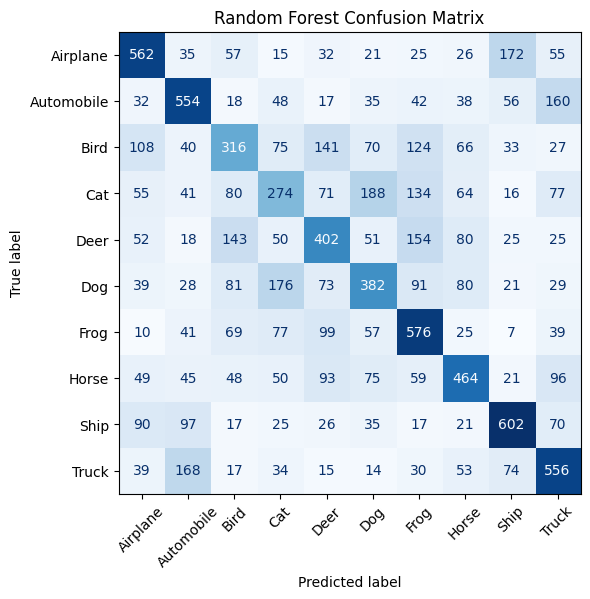

time: 245 ms (started: 2025-08-26 19:46:23 +00:00)


In [29]:
plot_confusion_matrix(y_pred_rf, y_test, class_names, "Random Forest")

In [30]:
get_diagonal(y_pred_rf, y_test, class_names, "Random Forest")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}]
time: 2.27 ms (started: 2025-08-26 19:46:23 +00:00)


Accuracy, while still not great, is much higher at 47%.  Good strong colours across the diagonal represent a higher level of correct predictions, with Frog and Ship particularly strong.  As could maybe be predicted there's some level of confusion around similar objects like Cat / Dog and Truck / Automobile.

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifer object
rf_grey = RandomForestClassifier()

# Train Decision Tree Classifer
rf_grey = rf_grey.fit(scaler_train_grey, y_train)

#Predict the response for test dataset
y_pred_rf_grey = rf_grey.predict(scaler_test_grey)

# Model Accuracy, how often is the classifier correct?
rf_acc_grey = accuracy_score(y_test, y_pred_rf_grey)
print("Accuracy:", rf_acc_grey)

Accuracy: 0.4102
time: 5min 10s (started: 2025-08-26 19:46:23 +00:00)


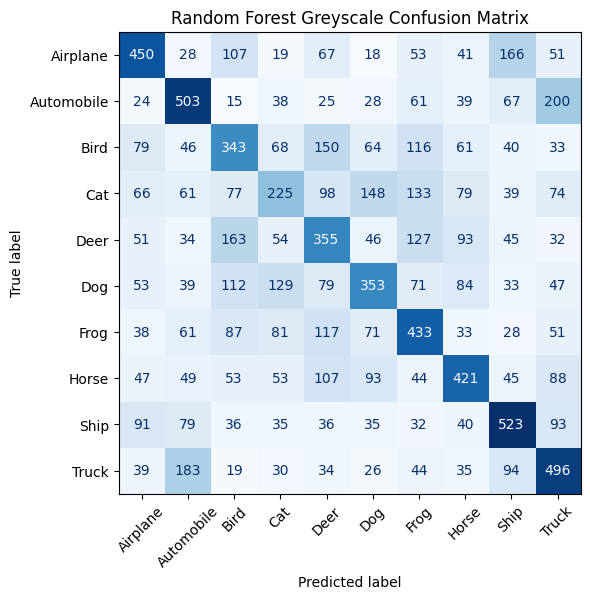

time: 245 ms (started: 2025-08-26 19:51:33 +00:00)


In [32]:
plot_confusion_matrix(y_pred_rf_grey, y_test, class_names, "Random Forest Greyscale")

In [33]:
get_diagonal(y_pred_rf_grey, y_test, class_names, "Random Forest Greyscale")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

Again greyscale doesn't improve accuracy,and only the Bird category sees any (small) improvement.

## SVM

In [34]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

# Create SVM classifer object
svm = make_pipeline(
    PCA(n_components=200), # without PCA this took 4.5 hours to run and only achieved 37% accuracy!
    LinearSVC(dual=False, tol=1e-4, max_iter = 5000)) # used LinearSVC as standard SVC couldnt handle the dataset

# Train Decision Tree Classifer
svm = svm.fit(scaler_train, y_train)

#Predict the response for test dataset
y_pred_svm = svm.predict(scaler_test)

# Model Accuracy, how often is the classifier correct?
svm_acc = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", svm_acc)

Accuracy: 0.4037
time: 49.9 s (started: 2025-08-26 19:51:34 +00:00)


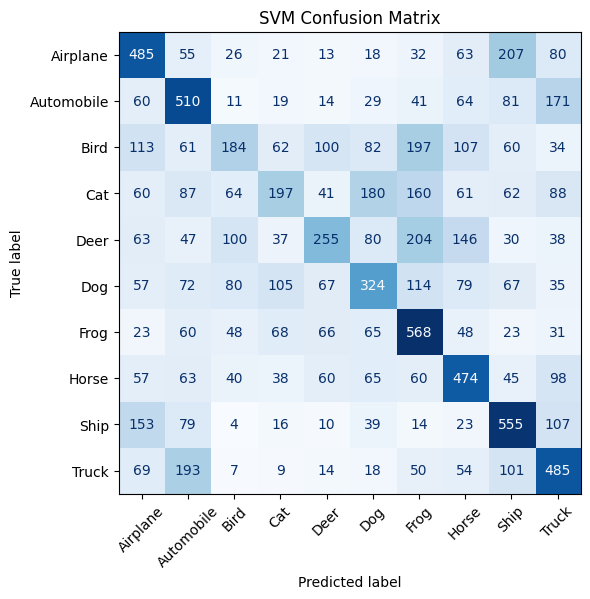

time: 272 ms (started: 2025-08-26 19:52:24 +00:00)


In [35]:
plot_confusion_matrix(y_pred_svm, y_test, class_names, "SVM")

In [36]:
get_diagonal(y_pred_svm, y_test, class_names, "SVM")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

Accuracy is worse than Random Forest at only 40%, and none of the categories has a higher level of correct predictions compared to Random Forest.

In [37]:
# Train Decision Tree Classifer
svm_grey = svm.fit(scaler_train_grey, y_train)

#Predict the response for test dataset
y_pred_svm_grey = svm.predict(scaler_test_grey)

# Model Accuracy, how often is the classifier correct?
svm_acc_grey = accuracy_score(y_test, y_pred_svm_grey)
print("Accuracy:", svm_acc_grey)

Accuracy: 0.2932
time: 37.3 s (started: 2025-08-26 19:52:24 +00:00)


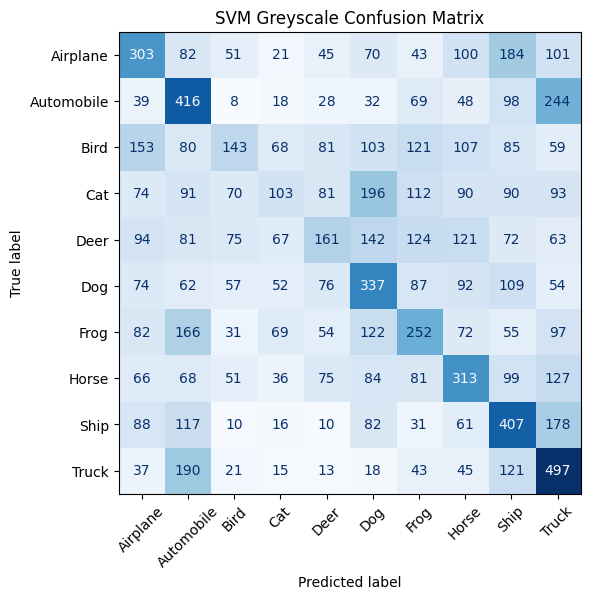

time: 275 ms (started: 2025-08-26 19:53:01 +00:00)


In [38]:
plot_confusion_matrix(y_pred_svm_grey, y_test, class_names, "SVM Greyscale")

In [39]:
get_diagonal(y_pred_svm_grey, y_test, class_names, "SVM Greyscale")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

So accuracy drops a lot here,but Dog and Truck see small individual improvements.

## XGBoost

Recent studies (Shao et.al., 2024, Ramdani & Furqon,2022) have suggested that XGBoost may be a good comparison for Random Forests in image classification tasks.  As this sits outof the Scikit Learn framework the library needs pulled in separately.

In [40]:
import xgboost as xgb

# Create SVM classifer object
xg_cl = xgb.XGBClassifier(n_estimators=10, objective='multi:softmax', num_class=10) # xgboost multivariate classifier


# Train Decision Tree Classifer
xg_cl = xg_cl.fit(scaler_train, y_train)

#Predict the response for test dataset
y_pred_xg = xg_cl.predict(scaler_test)

# Model Accuracy, how often is the classifier correct?
xgboost_acc = accuracy_score(y_test, y_pred_xg)
print("Accuracy:", xgboost_acc)

Accuracy: 0.4365
time: 1min 4s (started: 2025-08-26 19:53:01 +00:00)


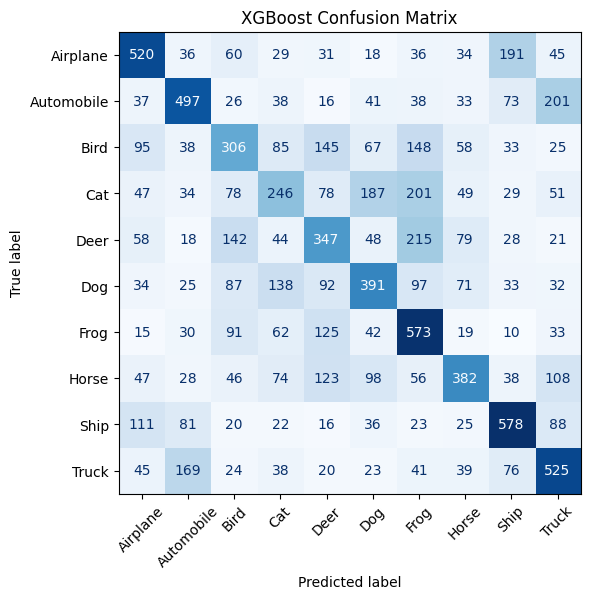

time: 243 ms (started: 2025-08-26 19:54:06 +00:00)


In [41]:
plot_confusion_matrix(y_pred_xg, y_test, class_names, "XGBoost")

In [42]:
get_diagonal(y_pred_xg, y_test, class_names, "XGBoost")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

Although not as good as Random Forest accuracy is better than the other models at 44%.  Again seeing good strong colours across the diagonal, with some categories such frog and ship being particularly strong, and the problem categories such as Cat / Dog, Airplane / Ship and Truck / Automobile again showing a higher level of confusion (although in this model lots of confusion with cats being labelled as frogs, which we didn't see as strongly in the other models).

In [43]:
import xgboost as xgb

# Create SVM classifer object
xg_cl_grey = xgb.XGBClassifier(n_estimators=10, objective='multi:softmax', num_class=10) # xgboost multivariate classifier

# Train Decision Tree Classifer
xg_cl_grey = xg_cl_grey.fit(scaler_train_grey, y_train)

#Predict the response for test dataset
y_pred_xg_grey = xg_cl_grey.predict(scaler_test_grey)

# Model Accuracy, how often is the classifier correct?
xgboost_acc_grey = accuracy_score(y_test, y_pred_xg_grey)
print("Accuracy:", xgboost_acc_grey)

Accuracy: 0.3698
time: 18.7 s (started: 2025-08-26 19:54:06 +00:00)


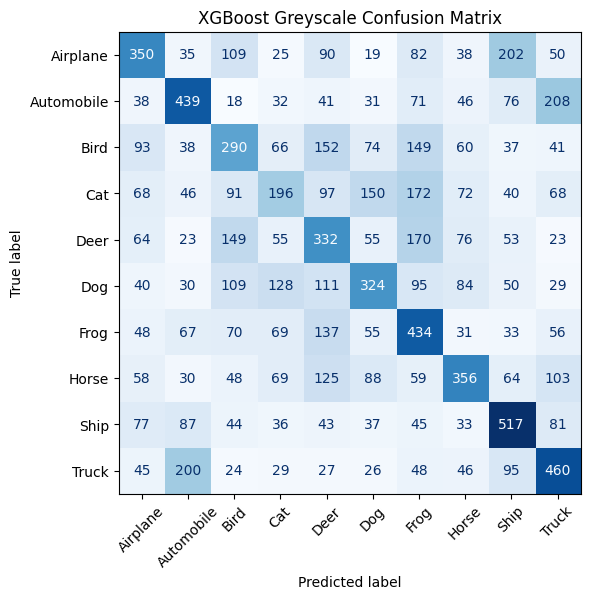

time: 249 ms (started: 2025-08-26 19:54:25 +00:00)


In [44]:
plot_confusion_matrix(y_pred_xg_grey, y_test, class_names, "XGBoost Greyscale")

In [45]:
get_diagonal(y_pred_xg_grey, y_test, class_names, "XGBoost Greyscale")
print(diagonals)

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

Before we move on to neural networks let's look at the results so far.

Following cell creates a nice highlighted table to show the model with the best metric

In [46]:
#(Highlighting code taken from here: https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/)

def highlight_max(s):
    if s.dtype == object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: green' if cell else '' for cell in is_max]

time: 795 µs (started: 2025-08-26 19:54:25 +00:00)


In [47]:
model_list = ["KMeans Clustering", "Decision Tree", "Decision Tree Greyscale", "Random Forest", "Random Forest Greyscale", "SVM", "SVM Greyscale", "XGBoost", "XGBoost Greyscale"]

accuracies = [kmeans_acc, tree_acc, tree_acc_grey, rf_acc, rf_acc_grey, svm_acc, svm_acc_grey, xgboost_acc, xgboost_acc_grey]

scores_dict = {'model': model_list,
               'Accuracy': accuracies
                }

scores_df = pd.DataFrame(scores_dict)

scores_df['Accuracy'] = scores_df['Accuracy'].apply(lambda x: float("{:.3f}".format(x)))
scores_df.style.apply(highlight_max)

,model,Accuracy
0,KMeans Clustering,0.127000
1,Decision Tree,0.269000
2,Decision Tree Greyscale,0.228000
3,Random Forest,0.469000
4,Random Forest Greyscale,0.410000
5,SVM,0.404000
6,SVM Greyscale,0.293000
7,XGBoost,0.436000
8,XGBoost Greyscale,0.370000


time: 93.8 ms (started: 2025-08-26 19:54:25 +00:00)


In [48]:
diagonals_df = pd.DataFrame(diagonals)
diagonals_df.style.apply(highlight_max)

,Model,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck
0,Decision Tree,345,271,222,177,234,224,269,277,379,292
1,Decision Tree Greyscale,282,239,190,146,195,206,211,224,318,270
2,Random Forest,562,554,316,274,402,382,576,464,602,556
3,Random Forest Greyscale,450,503,343,225,355,353,433,421,523,496
4,SVM,485,510,184,197,255,324,568,474,555,485
5,SVM Greyscale,303,416,143,103,161,337,252,313,407,497
6,XGBoost,520,497,306,246,347,391,573,382,578,525
7,XGBoost Greyscale,350,439,290,196,332,324,434,356,517,460


time: 7.76 ms (started: 2025-08-26 19:54:25 +00:00)


So far Random Forests has been the best performer, slightly better than XG Boost.  Moving to greyscale makes the performance slightly worse across all the models, so I won't use that going forwards.  Clustering is the least performative in terms of accuracy, only slightly better than random chance.

At an individual class level Random Forest is the best almost across all classes, with only small improvements in Bird, Dog and Horse in some of the other models.

# D) Neural Networks

I'm going to use the Keras framework to run the neural network section, so let's import the necessary libraries.

In [49]:
from keras import layers
from keras import models
from keras import optimizers

time: 387 µs (started: 2025-08-26 19:54:25 +00:00)


## Shallow Neural Network

First I'll create a simple neural network with one hidden layer,also sometimes called a shallow network.

In [50]:
#Basic code structure from (GeeksforGeeks, 2024)

# Initialize the model
shallow_model = models.Sequential()

# Add the hidden layer with 64 neurons and ReLU activation function
shallow_model.add(layers.Dense(64, activation = 'relu', input_shape = (32,32,3)))
shallow_model.add(layers.Flatten())

# Add the output layer with softmax activation function for multi-class classification
shallow_model.add(layers.Dense(10, activation = 'softmax'))

time: 2.1 s (started: 2025-08-26 19:54:25 +00:00)


In [51]:
shallow_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

time: 8.75 ms (started: 2025-08-26 19:54:27 +00:00)


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size = 20)
validation_generator = test_datagen.flow(X_test, y_test, batch_size = 20)

time: 176 ms (started: 2025-08-26 19:54:27 +00:00)


In [53]:
history = shallow_model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.1963 - loss: 3.5101 - val_accuracy: 0.3000 - val_loss: 1.9323
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3085 - loss: 1.9256 - val_accuracy: 0.3800 - val_loss: 1.8076
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3825 - loss: 1.7481 - val_accuracy: 0.4240 - val_loss: 1.6680
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4159 - loss: 1.7018 - val_accuracy: 0.4030 - val_loss: 1.6944
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3974 - loss: 1.7263 - val_accuracy: 0.4130 - val_loss: 1.6446
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4344 - loss: 1.6790 - val_accuracy: 0.3800 - val_loss: 1.7135
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4216 - loss: 1.6703 - val_accuracy: 0.4220 - val_loss: 1.6255
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4324 - loss: 1.6868 - val_accu

In [54]:
shallow_acc = history.history['val_accuracy'][-1]

print(shallow_acc)

0.4729999899864197
time: 484 µs (started: 2025-08-26 19:55:07 +00:00)


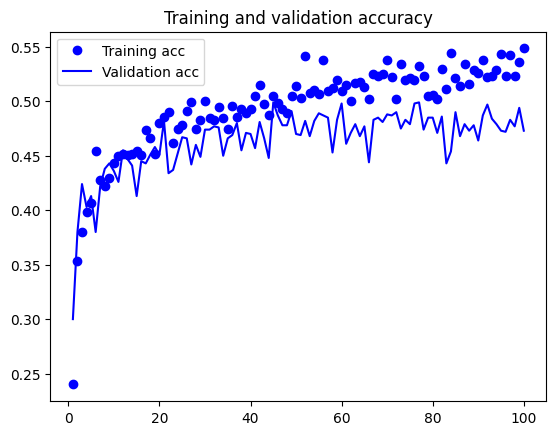

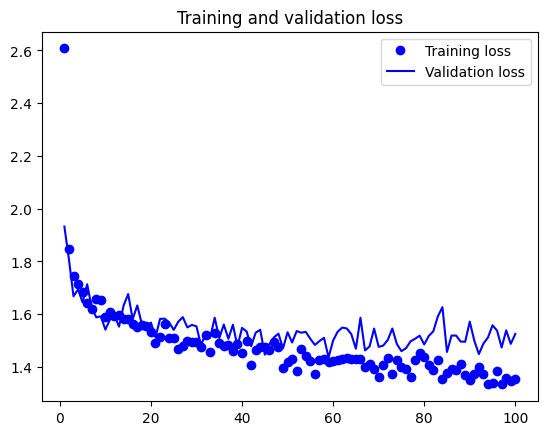

time: 246 ms (started: 2025-08-26 19:55:07 +00:00)


In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[[5]
 [7]
 [8]
 ...
 [7]
 [9]
 [4]]
[5 4 8 ... 3 2 7]


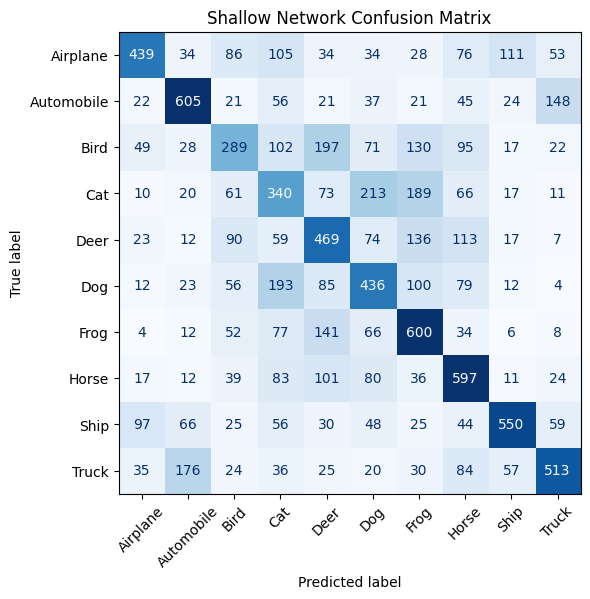

time: 1.96 s (started: 2025-08-26 19:55:07 +00:00)


In [56]:
y_true = []

for i in range(len(validation_generator)):
  _, y_batch = validation_generator[i]
  y_true.append(y_batch)
y_true = np.concatenate(y_true,axis = 0)
y_pred = shallow_model.predict(validation_generator, batch_size=20, verbose=0, steps=None, callbacks=None).argmax(axis=1)
print(y_true)
print(y_pred)

plot_confusion_matrix(y_pred, y_true, class_names, "Shallow Network")
get_diagonal(y_pred, y_true, class_names, "Shallow Network")

So even though this is a very simple model the accuracy is comparable to the most succesful of the algorithmic models above.  Now let's create something with a bit more depth.

## Convolutional Neural Network (CNN)

In [57]:
# (basic model structure from Chollet, 2018)

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (32,32,3)))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512, activation = 'relu'))
cnn_model.add(layers.Dense(10, activation = 'softmax'))

time: 67.4 ms (started: 2025-08-26 19:55:09 +00:00)


In [58]:
cnn_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

time: 4.46 ms (started: 2025-08-26 19:55:09 +00:00)


In [59]:
history = cnn_model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1559 - loss: 2.2558 - val_accuracy: 0.1760 - val_loss: 2.0593
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2389 - loss: 2.0333 - val_accuracy: 0.3200 - val_loss: 1.8500
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3048 - loss: 1.9425 - val_accuracy: 0.3530 - val_loss: 1.8055
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3350 - loss: 1.7910 - val_accuracy: 0.3200 - val_loss: 1.9244
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3693 - loss: 1.7082 - val_accuracy: 0.3870 - val_loss: 1.6866
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3973 - loss: 1.6191 - val_accuracy: 0.3920 - val_loss: 1.7026
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4145 - loss: 1.5961 - val_accuracy: 0.4630 - val_loss: 1.5148
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4579 - loss: 1.5102 - val_acc

In [60]:
cnn_acc = history.history['val_accuracy'][-1]

print(cnn_acc)

0.6809999942779541
time: 543 µs (started: 2025-08-26 19:55:55 +00:00)


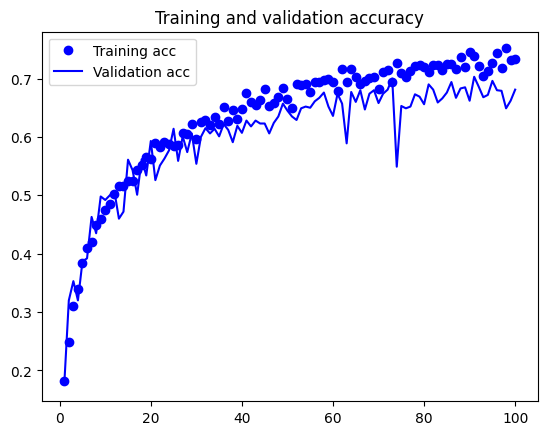

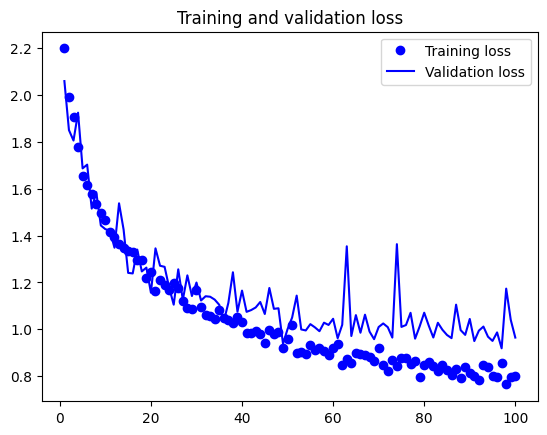

time: 249 ms (started: 2025-08-26 19:55:55 +00:00)


In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[[3]
 [1]
 [9]
 ...
 [1]
 [2]
 [8]]
[4 8 9 ... 8 0 1]


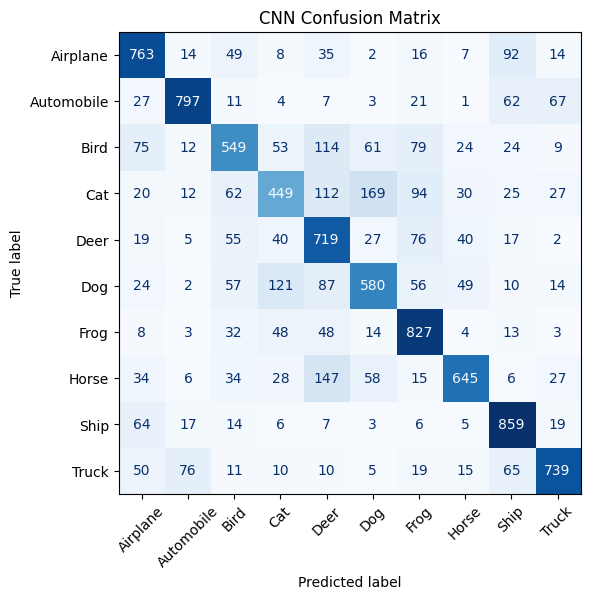

time: 2.05 s (started: 2025-08-26 19:55:55 +00:00)


In [62]:
y_true = []

for i in range(len(validation_generator)):
  _, y_batch = validation_generator[i]
  y_true.append(y_batch)
y_true = np.concatenate(y_true,axis = 0)
y_pred = cnn_model.predict(validation_generator, batch_size=20, verbose=0, steps=None, callbacks=None).argmax(axis=1)
print(y_true)
print(y_pred)

plot_confusion_matrix(y_pred, y_true, class_names, "CNN")
get_diagonal(y_pred, y_true, class_names, "CNN")

Accuracy is much better at 68%.  The model is showing very slight signs of overfitting - training accuracy is gradually improving, but test accuracy plateaus.  Let's try using some data augmentation to improve this, and also introducing dropout to the model.

In [63]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

time: 489 µs (started: 2025-08-26 19:55:57 +00:00)


In [64]:
cnn_aug_model = models.Sequential()
cnn_aug_model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (32,32,3)))
cnn_aug_model.add(layers.MaxPooling2D((2,2)))
cnn_aug_model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
cnn_aug_model.add(layers.MaxPooling2D((2,2)))
cnn_aug_model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
cnn_aug_model.add(layers.MaxPooling2D((2,2)))
cnn_aug_model.add(layers.Flatten())
cnn_aug_model.add(layers.Dropout(0.5))
cnn_aug_model.add(layers.Dense(512, activation = 'relu'))
cnn_aug_model.add(layers.Dense(10, activation = 'softmax'))

time: 70.8 ms (started: 2025-08-26 19:55:57 +00:00)


In [65]:
cnn_aug_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

time: 3.93 ms (started: 2025-08-26 19:55:57 +00:00)


In [66]:
# this code augments the images, applying things like rotation and flips

train_datagen2 = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen2 = ImageDataGenerator(rescale = 1./255)

train_generator2 = train_datagen2.flow(X_train, y_train, batch_size = 20)
validation_generator2 = test_datagen2.flow(X_test, y_test, batch_size = 20)

time: 178 ms (started: 2025-08-26 19:55:57 +00:00)


In [67]:
history = cnn_aug_model.fit(
    train_generator2,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator2,
    validation_steps = 50
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1232 - loss: 2.2768 - val_accuracy: 0.2230 - val_loss: 2.0554
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1893 - loss: 2.1171 - val_accuracy: 0.2750 - val_loss: 1.9214
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2188 - loss: 2.0452 - val_accuracy: 0.2710 - val_loss: 1.9114
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2427 - loss: 1.9687 - val_accuracy: 0.2970 - val_loss: 1.8493
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2636 - loss: 1.9566 - val_accuracy: 0.3360 - val_loss: 1.7763
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2847 - loss: 1.9169 - val_accuracy: 0.2020 - val_loss: 2.0881
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2583 - loss: 1.9390 - val_accuracy: 0.3460 - val_loss: 1.7341
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2936 - loss: 1.8557 - 

In [68]:
cnn_aug_acc = history.history['val_accuracy'][-1]

print(cnn_aug_acc)

0.5180000066757202
time: 557 µs (started: 2025-08-26 19:58:12 +00:00)


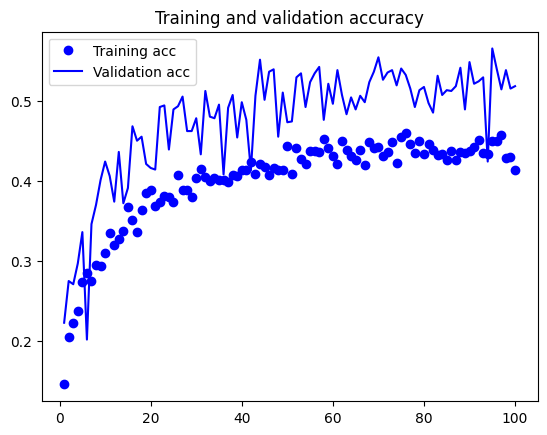

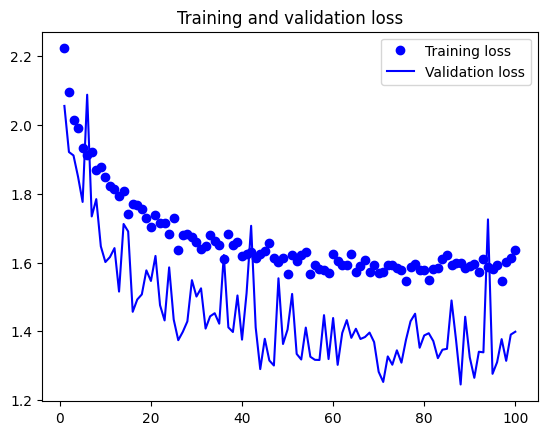

time: 234 ms (started: 2025-08-26 19:58:12 +00:00)


In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[[2]
 [1]
 [4]
 ...
 [4]
 [1]
 [3]]
[5 1 4 ... 6 1 6]


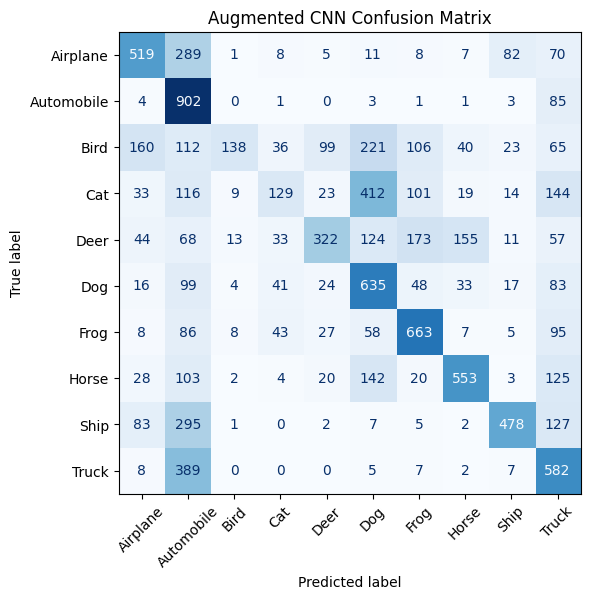

time: 2.06 s (started: 2025-08-26 19:58:12 +00:00)


In [70]:
y_true = []

for i in range(len(validation_generator2)):
  _, y_batch = validation_generator2[i]
  y_true.append(y_batch)
y_true = np.concatenate(y_true,axis = 0)
y_pred = cnn_aug_model.predict(validation_generator2, batch_size=20, verbose=0, steps=None, callbacks=None).argmax(axis=1)
print(y_true)
print(y_pred)

plot_confusion_matrix(y_pred, y_true, class_names, "Augmented CNN")
get_diagonal(y_pred, y_true, class_names, "Augmented CNN")

So the overfitting has changed to underfitting, and accuracy has taken a hit - as the previous overfitting was only slight let's use the original data generators going forward.  Now let's try hyper-parameter tuning to improve the performance.

# E) Hyperparameter Optimization

(Tuning adapted from Optuna, 2021)

In [71]:
!pip install optuna
!pip install optuna-integration[keras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.5 MB/s eta 0:00:00
time: 11.5 s (started: 2025-08-26 19:58:14 +00:00)


In [72]:
import optuna
import keras
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState

time: 47 ms (started: 2025-08-26 19:58:26 +00:00)


In [73]:
N_TRAIN_EXAMPLES = 50000
N_VALID_EXAMPLES = 10000
BATCHSIZE = 128
CLASSES = 10
EPOCHS = 50


def create_model(trial):
    # We optimize the number of layers, hidden units and dropout in each layer and
    # the learning rate of RMSProp optimizer.

    # We define our MLP.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (32,32,3)))
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)
        model.add(layers.Dense(num_hidden, activation="relu"))
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        model.add(layers.Dropout(rate=dropout))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(CLASSES, activation="softmax"))

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer='rmsprop',
        metrics=["accuracy"],
    )

    return model


def objective(trial):
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()

    # Generate our trial model.
    model = create_model(trial)

    # Fit the model on the training data.
    # The KerasPruningCallback checks for pruning condition every epoch.
    model.fit(
        train_generator,
        steps_per_epoch = 100,
        batch_size=BATCHSIZE,
        callbacks=[KerasPruningCallback(trial, "val_accuracy")],
        epochs=EPOCHS,
        validation_data=validation_generator,
        verbose=1
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(validation_generator, verbose=0)
    return score[1]

time: 1.85 ms (started: 2025-08-26 19:58:26 +00:00)


In [74]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-08-26 19:58:26,502] A new study created in memory with name: no-name-318ff6c6-9903-491b-b587-e0ebd3fcbdda


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.1907 - loss: 3.5258 - val_accuracy: 0.3515 - val_loss: 1.8115
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3217 - loss: 1.8480 - val_accuracy: 0.4050 - val_loss: 1.6544
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3972 - loss: 1.6930 - val_accuracy: 0.4258 - val_loss: 1.5836
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4553 - loss: 1.5302 - val_accuracy: 0.4088 - val_loss: 1.6603
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4496 - loss: 1.4801 - val_accuracy: 0.4725 - val_loss: 1.4896
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4797 - loss: 1.4541 - val_accuracy: 0.4721 - val_loss: 1.4605
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4876 - loss: 1.4104 - val_accuracy: 0.4992 - val_loss: 1.3910
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5242 - loss: 1.3334 - val_acc

[I 2025-08-26 19:59:46,457] Trial 0 finished with value: 0.6208000183105469 and parameters: {'n_layers': 1, 'n_units_l0': 117, 'dropout_l0': 0.21778449175751363, 'learning_rate': 0.0019250886300879323}. Best is trial 0 with value: 0.6208000183105469.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.1824 - loss: 3.9883 - val_accuracy: 0.3185 - val_loss: 1.9317
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2855 - loss: 1.9693 - val_accuracy: 0.3223 - val_loss: 1.8129
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3196 - loss: 1.8500 - val_accuracy: 0.4266 - val_loss: 1.6487
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3859 - loss: 1.7331 - val_accuracy: 0.3957 - val_loss: 1.6780
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3934 - loss: 1.6724 - val_accuracy: 0.4524 - val_loss: 1.5374
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4173 - loss: 1.6435 - val_accuracy: 0.4408 - val_loss: 1.5420
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4447 - loss: 1.5550 - val_accuracy: 0.4562 - val_loss: 1.5041
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4702 - loss: 1.4926 - val_acc

[I 2025-08-26 20:01:08,755] Trial 1 finished with value: 0.5918999910354614 and parameters: {'n_layers': 2, 'n_units_l0': 35, 'dropout_l0': 0.2417957246145142, 'n_units_l1': 79, 'dropout_l1': 0.46801819630648994, 'learning_rate': 0.018877727500314478}. Best is trial 0 with value: 0.6208000183105469.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.1340 - loss: 2.2612 - val_accuracy: 0.3263 - val_loss: 1.9453
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2950 - loss: 1.9615 - val_accuracy: 0.3607 - val_loss: 1.8296
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3260 - loss: 1.8487 - val_accuracy: 0.3625 - val_loss: 1.7523
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3319 - loss: 1.8684 - val_accuracy: 0.3678 - val_loss: 1.7651
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3985 - loss: 1.7264 - val_accuracy: 0.3835 - val_loss: 1.7171
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3831 - loss: 1.7192 - val_accuracy: 0.4189 - val_loss: 1.6362
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3884 - loss: 1.7075 - val_accuracy: 0.3665 - val_loss: 1.7536
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4356 - loss: 1.6314 - val_accu

[I 2025-08-26 20:02:24,087] Trial 2 finished with value: 0.5238999724388123 and parameters: {'n_layers': 2, 'n_units_l0': 18, 'dropout_l0': 0.38023321354967304, 'n_units_l1': 8, 'dropout_l1': 0.27401621577848356, 'learning_rate': 2.016525512686015e-05}. Best is trial 0 with value: 0.6208000183105469.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.1592 - loss: 4.1194 - val_accuracy: 0.3293 - val_loss: 1.9121
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2904 - loss: 1.9664 - val_accuracy: 0.3643 - val_loss: 1.7488
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3668 - loss: 1.7629 - val_accuracy: 0.4131 - val_loss: 1.6228
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3884 - loss: 1.6606 - val_accuracy: 0.4333 - val_loss: 1.5573
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4220 - loss: 1.6220 - val_accuracy: 0.4476 - val_loss: 1.5310
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4597 - loss: 1.5542 - val_accuracy: 0.4673 - val_loss: 1.4644
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4505 - loss: 1.5111 - val_accuracy: 0.4365 - val_loss: 1.5421
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5023 - loss: 1.4242 - val_accu

[I 2025-08-26 20:03:41,249] Trial 3 finished with value: 0.6031000018119812 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout_l0': 0.35714068999013726, 'learning_rate': 0.04758510173660907}. Best is trial 0 with value: 0.6208000183105469.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.1159 - loss: 2.2868 - val_accuracy: 0.1914 - val_loss: 2.2813
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2512 - loss: 2.0688 - val_accuracy: 0.2811 - val_loss: 1.9314
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3156 - loss: 1.9210 - val_accuracy: 0.3321 - val_loss: 1.7990
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3305 - loss: 1.8367 - val_accuracy: 0.3869 - val_loss: 1.7382
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3528 - loss: 1.7549 - val_accuracy: 0.3961 - val_loss: 1.7273
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3852 - loss: 1.7303 - val_accuracy: 0.4251 - val_loss: 1.6286
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4170 - loss: 1.6653 - val_accuracy: 0.3903 - val_loss: 1.7049
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3934 - loss: 1.7208 - val_accu

[I 2025-08-26 20:04:54,505] Trial 4 finished with value: 0.5304999947547913 and parameters: {'n_layers': 1, 'n_units_l0': 4, 'dropout_l0': 0.3816120787272186, 'learning_rate': 0.009256579070048855}. Best is trial 0 with value: 0.6208000183105469.


Epoch 1/50
 86/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1422 - loss: 2.3580

[I 2025-08-26 20:05:04,735] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1614 - loss: 2.2308

[I 2025-08-26 20:05:11,268] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 88/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1516 - loss: 2.4595

[I 2025-08-26 20:05:19,798] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1241 - loss: 4.4445

[I 2025-08-26 20:05:35,485] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.2196 - loss: 2.7372 - val_accuracy: 0.3423 - val_loss: 1.7996
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3375 - loss: 1.8312 - val_accuracy: 0.3958 - val_loss: 1.6510
Epoch 3/50
 81/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3935 - loss: 1.7056

[I 2025-08-26 20:05:48,704] Trial 9 pruned. Trial was pruned at epoch 2.


Epoch 1/50
 85/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1035 - loss: 2.2940

[I 2025-08-26 20:05:59,297] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1420 - loss: 7.3596

[I 2025-08-26 20:06:10,305] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1356 - loss: 4.9874

[I 2025-08-26 20:06:20,373] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1385 - loss: 2.5134

[I 2025-08-26 20:06:32,975] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1767 - loss: 3.8643 - val_accuracy: 0.3752 - val_loss: 1.8169
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3183 - loss: 1.8614 - val_accuracy: 0.3304 - val_loss: 1.7898
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3833 - loss: 1.7065

[I 2025-08-26 20:06:44,574] Trial 14 pruned. Trial was pruned at epoch 2.


Epoch 1/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1582 - loss: 2.3730

[I 2025-08-26 20:06:56,186] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1753 - loss: 6.1123

[I 2025-08-26 20:07:06,147] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 85/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1439 - loss: 2.2780

[I 2025-08-26 20:07:15,837] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 81/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1215 - loss: 2.3989

[I 2025-08-26 20:07:30,183] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1363 - loss: 2.2695

[I 2025-08-26 20:07:39,129] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1471 - loss: 2.2671

[I 2025-08-26 20:07:47,564] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 90/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1586 - loss: 2.8041

[I 2025-08-26 20:07:59,777] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 93/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1380 - loss: 3.0507

[I 2025-08-26 20:08:11,156] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1803 - loss: 3.9952

[I 2025-08-26 20:08:21,819] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 92/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1617 - loss: 2.9607

[I 2025-08-26 20:08:32,391] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1650 - loss: 3.7659

[I 2025-08-26 20:08:42,518] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1620 - loss: 3.1273

[I 2025-08-26 20:08:52,399] Trial 26 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 90/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1588 - loss: 4.4335

[I 2025-08-26 20:09:03,674] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 83/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1452 - loss: 3.1996

[I 2025-08-26 20:09:18,190] Trial 28 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 81/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1404 - loss: 2.3567

[I 2025-08-26 20:09:29,677] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 86/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1344 - loss: 3.3022

[I 2025-08-26 20:09:39,844] Trial 30 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2030 - loss: 2.4214

[I 2025-08-26 20:09:48,464] Trial 31 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1565 - loss: 2.2309

[I 2025-08-26 20:09:57,650] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1318 - loss: 2.2618

[I 2025-08-26 20:10:03,326] Trial 33 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 88/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1296 - loss: 2.3125

[I 2025-08-26 20:10:08,865] Trial 34 pruned. Trial was pruned at epoch 0.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.1841 - loss: 2.3551 - val_accuracy: 0.3451 - val_loss: 1.8462
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3313 - loss: 1.8743 - val_accuracy: 0.3820 - val_loss: 1.7352
Epoch 3/50
 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3608 - loss: 1.8022

[I 2025-08-26 20:10:18,188] Trial 35 pruned. Trial was pruned at epoch 2.


Epoch 1/50
 84/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1355 - loss: 2.6229

[I 2025-08-26 20:10:23,775] Trial 36 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 95/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1823 - loss: 3.2025

[I 2025-08-26 20:10:34,113] Trial 37 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 88/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1503 - loss: 2.3893

[I 2025-08-26 20:10:42,901] Trial 38 pruned. Trial was pruned at epoch 0.


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1370 - loss: 6.2272

[I 2025-08-26 20:10:53,647] Trial 39 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 81/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1548 - loss: 3.1878

[I 2025-08-26 20:10:59,517] Trial 40 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1283 - loss: 2.3875

[I 2025-08-26 20:11:09,814] Trial 41 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1489 - loss: 2.2690

[I 2025-08-26 20:11:19,256] Trial 42 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 86/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1503 - loss: 2.3490

[I 2025-08-26 20:11:31,669] Trial 43 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1316 - loss: 2.4436

[I 2025-08-26 20:11:43,939] Trial 44 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1580 - loss: 3.7622

[I 2025-08-26 20:11:54,851] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 94/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1556 - loss: 3.8676

[I 2025-08-26 20:12:07,794] Trial 46 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 90/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1474 - loss: 4.3551

[I 2025-08-26 20:12:16,171] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 86/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1459 - loss: 2.3618

[I 2025-08-26 20:12:24,348] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/50
 81/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1637 - loss: 2.2334

[I 2025-08-26 20:12:29,991] Trial 49 pruned. Trial was pruned at epoch 0.


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  45
  Number of complete trials:  5
Best trial:
  Value:  0.6208000183105469
  Params: 
    n_layers: 1
    n_units_l0: 117
    dropout_l0: 0.21778449175751363
    learning_rate: 0.0019250886300879323
time: 14min 3s (started: 2025-08-26 19:58:26 +00:00)


Now let's create a model with the best parameters from above and run for the same time as the original models (note - the hyperparameter tuning will give slightly results every time depending on the experiments run)

In [78]:
hyper_model = models.Sequential()
hyper_model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (32,32,3)))
hyper_model.add(layers.MaxPooling2D((2,2)))
hyper_model.add(layers.Conv2D(117,(3,3), activation = 'relu'))
hyper_model.add(layers.Dropout(0.21778))
hyper_model.add(layers.Flatten())
hyper_model.add(layers.Dense(512, activation = 'relu'))
hyper_model.add(layers.Dense(10, activation = 'softmax'))

time: 51.4 ms (started: 2025-08-26 20:17:30 +00:00)


In [79]:
optimizer = optimizers.RMSprop(learning_rate= 0.001925)  # learning rate from above
hyper_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

time: 4.9 ms (started: 2025-08-26 20:17:33 +00:00)


In [80]:
history = hyper_model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1394 - loss: 3.3054 - val_accuracy: 0.2570 - val_loss: 2.0243
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3063 - loss: 1.9557 - val_accuracy: 0.3550 - val_loss: 1.7239
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3717 - loss: 1.7687 - val_accuracy: 0.4630 - val_loss: 1.5002
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4361 - loss: 1.6569 - val_accuracy: 0.4320 - val_loss: 1.5805
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4527 - loss: 1.5519 - val_accuracy: 0.4630 - val_loss: 1.4634
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4593 - loss: 1.5376 - val_accuracy: 0.4750 - val_loss: 1.4501
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4867 - loss: 1.4888 - val_accuracy: 0.5140 - val_loss: 1.3016
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4808 - loss: 1.4192 - val_acc

In [81]:
hyper_acc = history.history['val_accuracy'][-1]

print(hyper_acc)

0.671999990940094
time: 530 µs (started: 2025-08-26 20:20:14 +00:00)


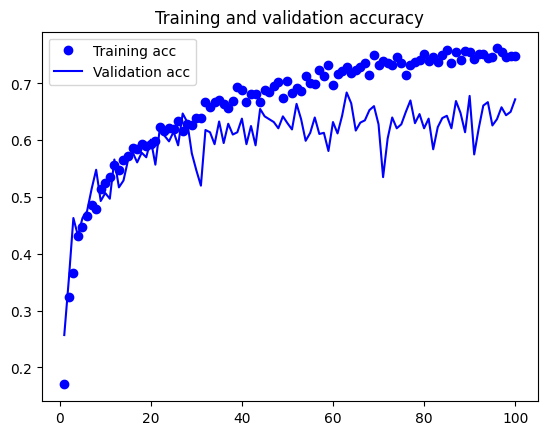

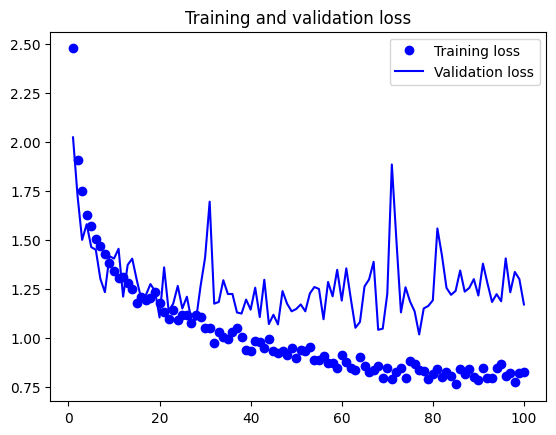

time: 250 ms (started: 2025-08-26 20:20:18 +00:00)


In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[[2]
 [0]
 [4]
 ...
 [2]
 [4]
 [2]]
[2 0 4 ... 2 2 0]


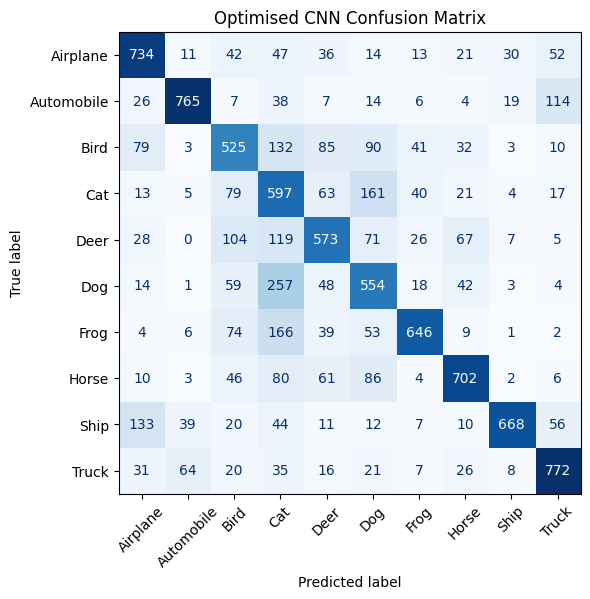

time: 2.13 s (started: 2025-08-26 20:20:34 +00:00)


In [83]:
y_true = []

for i in range(len(validation_generator)):
  _, y_batch = validation_generator[i]
  y_true.append(y_batch)
y_true = np.concatenate(y_true,axis = 0)
y_pred = hyper_model.predict(validation_generator, batch_size=20, verbose=0, steps=None, callbacks=None).argmax(axis=1)
print(y_true)
print(y_pred)

plot_confusion_matrix(y_pred, y_true, class_names, "Optimised CNN")
get_diagonal(y_pred, y_true, class_names, "Optimised CNN")

Accuracy is on a par with the original CNN model above, suggesting the original CNN architecture suggested by Chollet is pretty good for data / size of dataset. (I've run this optimisation code several times and the performance is always around this level, i.e. similar to the original CNN model.)

## Pre-trained model

Now lets try a model based on a pre-trained model using the ResNet residual network architecture (Keras, n.d.) as this should be well suited to image classification (Geron, 2018),and has performed well on the CIFAR10 data in previous studies (Krithika & Gayathri, 2024).  I'll try two versions of this, ResNet50 and ResNet152, by adding our classification task to the frozen convolutional base,then on the most performative model I'll unfreeze the last layer and fine tune the model based on the CIFAR data.


First I need to create a new confusion matrix function due to the pre-processing required for the images.

In [84]:
def nn_cm_stats(model):
  # note - this step necessary as the step required to transform the data shuffles the data so this makes
  # sure the test and true values line up and are in the correct format

  y_true = []
  y_pred =[]

  for element in X_test_224:
    pred = model.predict(element[0])
    pred = np.argmax(pred, axis = 1)
    y_pred.append(pred)
    y_true.append(element[1])

  print(y_true[-1])

  y_pred_total = []
  for element in y_pred:
    for number in element:
      y_pred_total.append(number)

  y_true_total = []
  for element in y_true:
    for number in element:
      y_true_total.append(number.numpy())


  print(y_pred[-1])
  print(y_true[-1])

  y_pred_all = np.concatenate(y_pred).tolist()
  y_true_all = np.concatenate(y_true).tolist()

  return y_pred_all,y_true_all

time: 1.13 ms (started: 2025-08-26 20:23:49 +00:00)


# ResNet50

In [85]:
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
resnet50_model = models.Sequential()
resnet50_model.add(conv_base)
resnet50_model.add(layers.GlobalAveragePooling2D())
resnet50_model.add(layers.Dense(256, activation = 'relu'))
resnet50_model.add(layers.Dropout(0.5))
resnet50_model.add(layers.Dense(10, activation = 'softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
time: 6.76 s (started: 2025-08-26 20:23:49 +00:00)


In [86]:
conv_base.trainable = False

resnet50_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

time: 6.86 ms (started: 2025-08-26 20:23:56 +00:00)


In [87]:
import tensorflow as tf

#needed to add this pre-processing stage as Colab ran out of ram and crashed if I tried to process in one big go

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
  image = tf.image.resize(image, (224, 224))
  image = tf.cast(image, tf.float32)
  image = preprocess_input(image)
  return (image, label) # Return as a single tuple

X_train_224 = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(64).prefetch(AUTOTUNE)
X_test_224 = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(64).prefetch(AUTOTUNE)

time: 685 ms (started: 2025-08-26 20:23:56 +00:00)


In [88]:
history = resnet50_model.fit(
    X_train_224,
    steps_per_epoch = 100,
    epochs = 10, #any more than this doesn't really improve the numbers
    validation_data = X_test_224,
    validation_steps = 50
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.5692 - loss: 1.6117 - val_accuracy: 0.8541 - val_loss: 0.4141
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8025 - loss: 0.5930 - val_accuracy: 0.8697 - val_loss: 0.3784
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8261 - loss: 0.5274 - val_accuracy: 0.8747 - val_loss: 0.3913
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8397 - loss: 0.4695 - val_accuracy: 0.8687 - val_loss: 0.3541
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8411 - loss: 0.4653 - val_accuracy: 0.8797 - val_loss: 0.3505
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8437 - loss: 0.4715 - val_accuracy: 0.8744 - val_loss: 0.3534
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8470 - loss: 0.4826 - val_accuracy: 0.8834 - val_loss: 0.3552
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.8622 - loss: 0.4227 - val_

In [89]:
resnet50_acc = history.history['val_accuracy'][-1]

print(resnet50_acc)

0.8849999904632568
time: 512 µs (started: 2025-08-26 20:25:18 +00:00)


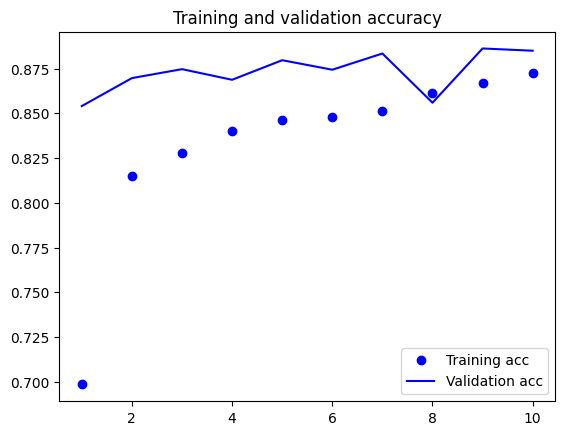

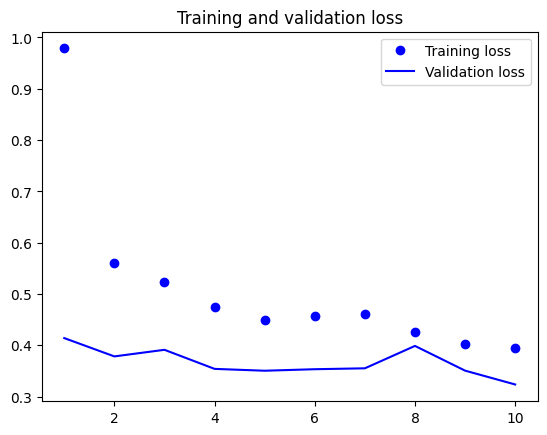

time: 246 ms (started: 2025-08-26 20:25:18 +00:00)


In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━

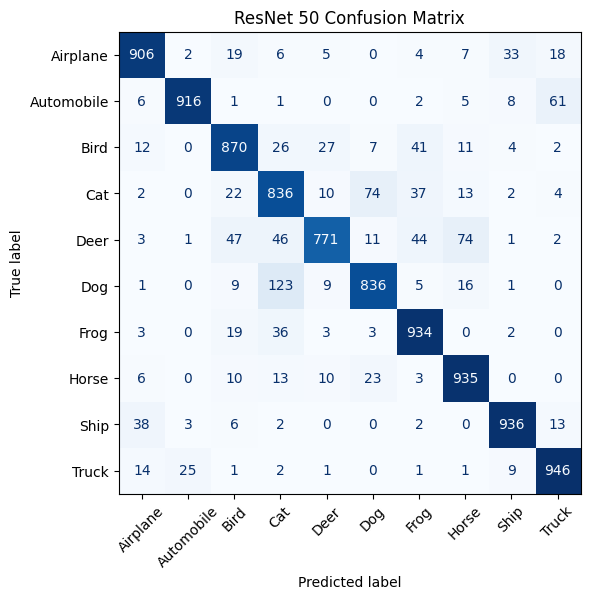

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

In [91]:
resnet50_pred, resnet50_true = nn_cm_stats(resnet50_model)
plot_confusion_matrix(resnet50_pred, resnet50_true, class_names, "ResNet 50")
get_diagonal(resnet50_pred, resnet50_true, class_names, "ResNet 50")
print(diagonals)

Performance is considerably better than any of the previous models, showing that the features the ResNet50 model has learned previously are also applicable & transferable to the CIFAR10 dataset.

 ## ResNet152

In [92]:
from keras.applications import ResNet152

conv_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
resnet152_model = models.Sequential()
resnet152_model.add(conv_base)
resnet152_model.add(layers.GlobalAveragePooling2D())
resnet152_model.add(layers.Dense(256, activation = 'relu'))
resnet152_model.add(layers.Dropout(0.5))
resnet152_model.add(layers.Dense(10, activation = 'softmax'))

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
time: 14.7 s (started: 2025-08-26 20:25:53 +00:00)


In [93]:
conv_base.trainable = False

resnet152_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

time: 9.81 ms (started: 2025-08-26 20:26:08 +00:00)


In [94]:
history = resnet152_model.fit(
    X_train_224,
    steps_per_epoch = 100,
    epochs = 20,
    validation_data = X_test_224,
    validation_steps = 50
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - accuracy: 0.6362 - loss: 1.3462 - val_accuracy: 0.8725 - val_loss: 0.3820
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8461 - loss: 0.4701 - val_accuracy: 0.8822 - val_loss: 0.3359
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8588 - loss: 0.4250 - val_accuracy: 0.9056 - val_loss: 0.2808
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8736 - loss: 0.3950 - val_accuracy: 0.8997 - val_loss: 0.2848
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8813 - loss: 0.3637 - val_accuracy: 0.9009 - val_loss: 0.2992
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8826 - loss: 0.3689 - val_accuracy: 0.9072 - val_loss: 0.2671
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8835 - loss: 0.3545 - val_accuracy: 0.9066 - val_loss: 0.2886
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.8897 - loss: 0.3586 

In [95]:
resnet152_acc = history.history['val_accuracy'][-1]

print(resnet152_acc)

0.9206249713897705
time: 490 µs (started: 2025-08-26 20:30:06 +00:00)


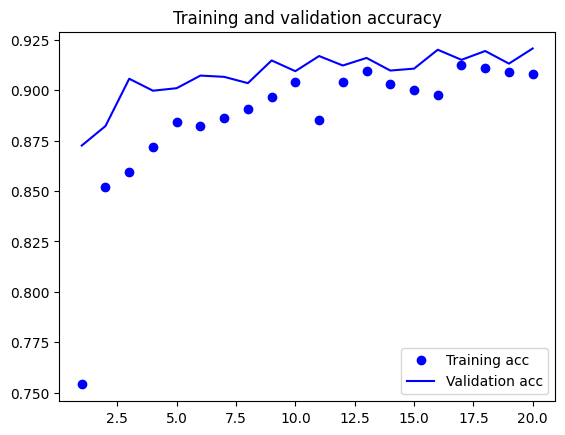

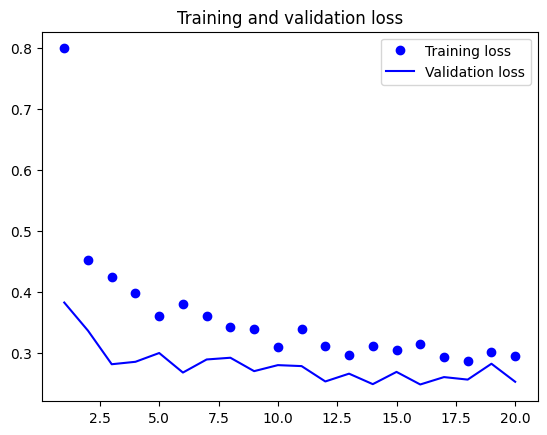

time: 253 ms (started: 2025-08-26 20:30:06 +00:00)


In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━

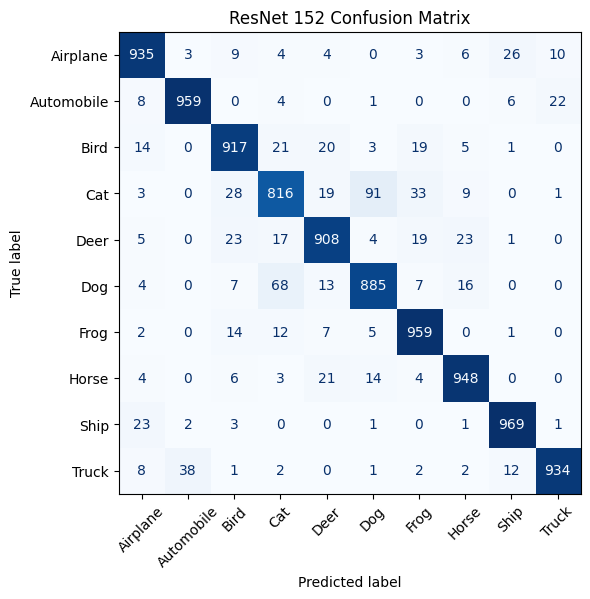

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

In [97]:
resnet152_pred, resnet152_true = nn_cm_stats(resnet152_model)
plot_confusion_matrix(resnet152_pred, resnet152_true, class_names, "ResNet 152")
get_diagonal(resnet152_pred, resnet152_true, class_names, "ResNet 152")
print(diagonals)

So both models are significantly better than what we've tried before, but accuracy of ResNet152 is a few percentage points better, which at this higher level of performance is very significant.  Now let's see if we can improve this even further with fine tuning.  First let's have a look at the model.

In [98]:
conv_base.summary()

Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

time: 425 ms (started: 2025-08-26 20:30:54 +00:00)


The last layer here is Conv5, so let's make everything in this layer trainable by setting everything from conv5_block1_1_conv onwards to trainable (Chollet, 2018)

In [99]:
conv_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
resnet152_ft_model = models.Sequential()
resnet152_ft_model.add(conv_base)
resnet152_ft_model.add(layers.GlobalAveragePooling2D())
resnet152_ft_model.add(layers.Dense(256, activation = 'relu'))
resnet152_ft_model.add(layers.Dropout(0.5))
resnet152_ft_model.add(layers.Dense(10, activation = 'softmax'))

time: 2.82 s (started: 2025-08-26 20:30:55 +00:00)


In [100]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv5_block1_1_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

time: 5.29 ms (started: 2025-08-26 20:30:58 +00:00)


In [101]:
resnet152_ft_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = resnet152_ft_model.fit(
    X_train_224,
    steps_per_epoch = 100,
    epochs = 50,  #performance flattensout after this point
    validation_data = X_test_224,
    validation_steps = 50
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 205ms/step - accuracy: 0.7148 - loss: 1.0799 - val_accuracy: 0.2694 - val_loss: 134.5069
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8900 - loss: 0.3706 - val_accuracy: 0.6997 - val_loss: 10.0112
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8851 - loss: 0.3730 - val_accuracy: 0.8797 - val_loss: 0.6000
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8971 - loss: 0.3109 - val_accuracy: 0.8934 - val_loss: 0.4667
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9184 - loss: 0.2439 - val_accuracy: 0.9025 - val_loss: 0.3312
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9248 - loss: 0.2332 - val_accuracy: 0.9222 - val_loss: 0.2785
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9268 - loss: 0.2308 - val_accuracy: 0.9169 - val_loss: 0.2867
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.9237 - loss

In [102]:
resnet152_ft_acc = history.history['val_accuracy'][-1]

print(resnet152_ft_acc)

0.9559375047683716
time: 494 µs (started: 2025-08-26 20:40:31 +00:00)


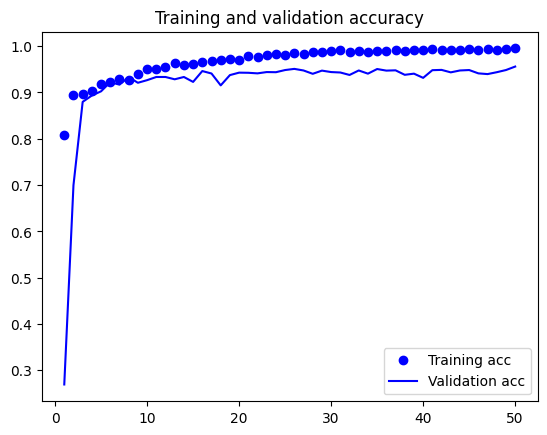

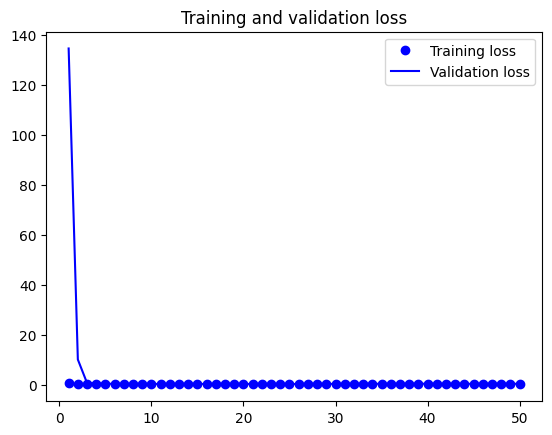

time: 257 ms (started: 2025-08-26 20:40:31 +00:00)


In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

So significantly better again at ~95% accuracy.  Now let's create a confusion matrix to see where the improvements are.

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━

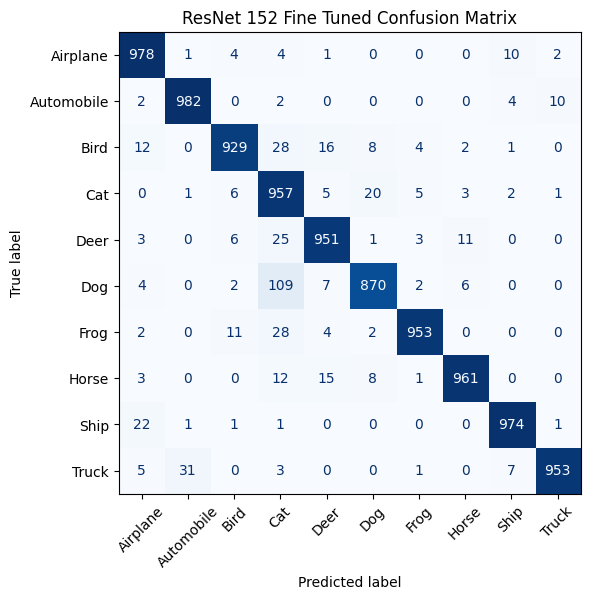

[{'Model': 'Decision Tree', 'Airplane': np.int64(345), 'Automobile': np.int64(271), 'Bird': np.int64(222), 'Cat': np.int64(177), 'Deer': np.int64(234), 'Dog': np.int64(224), 'Frog': np.int64(269), 'Horse': np.int64(277), 'Ship': np.int64(379), 'Truck': np.int64(292)}, {'Model': 'Decision Tree Greyscale', 'Airplane': np.int64(282), 'Automobile': np.int64(239), 'Bird': np.int64(190), 'Cat': np.int64(146), 'Deer': np.int64(195), 'Dog': np.int64(206), 'Frog': np.int64(211), 'Horse': np.int64(224), 'Ship': np.int64(318), 'Truck': np.int64(270)}, {'Model': 'Random Forest', 'Airplane': np.int64(562), 'Automobile': np.int64(554), 'Bird': np.int64(316), 'Cat': np.int64(274), 'Deer': np.int64(402), 'Dog': np.int64(382), 'Frog': np.int64(576), 'Horse': np.int64(464), 'Ship': np.int64(602), 'Truck': np.int64(556)}, {'Model': 'Random Forest Greyscale', 'Airplane': np.int64(450), 'Automobile': np.int64(503), 'Bird': np.int64(343), 'Cat': np.int64(225), 'Deer': np.int64(355), 'Dog': np.int64(353), 'F

In [104]:
resnet152_ft_pred, resnet152_ft_true = nn_cm_stats(resnet152_ft_model)
plot_confusion_matrix(resnet152_ft_pred, resnet152_ft_true, class_names, "ResNet 152 Fine Tuned")
get_diagonal(resnet152_ft_pred, resnet152_ft_true, class_names, "ResNet 152 Fine Tuned")
print(diagonals)

So the dark blue diagonal reflects what we're seeing in the accuracy stat - very solid performance, with the main confusion being a small amount of mistakes with cats and dogs.

## Inference Time

Now I'll create a function to determine inference time for a sample object for some of the better performing models

In [105]:
# for inference timing - just need a sample with the correct shape, as we're not looking for accuracy here

model_list = [
    [rf, scaler_train[0].reshape(1,-1), 'Random Forest'],
    [xg_cl,scaler_train[0].reshape(1,-1), 'XGBoost'],
    [shallow_model, train_generator[0][0], 'Shallow Network'],
    [cnn_model,train_generator[0][0], 'CNN'],
    [resnet50_model, np.random.rand(1, 224, 224, 3).astype(np.float32), 'ResNet50'],
    [resnet152_ft_model, np.random.rand(1, 224, 224, 3).astype(np.float32), 'ResNet152 Fine Tuned']
]

time: 5.65 ms (started: 2025-08-26 20:41:19 +00:00)


In [106]:
import time

#  this function tells us how long each model takes to determine a category - uses an average as individual runs can be inconclusive

def inference_time(model):
  print(model[2])
  runs = 100
  start = time.perf_counter()
  for run in range(runs):
    model[0].predict(model[1])
  end = time.perf_counter()

  average_time = (end - start) / runs
  return average_time

time: 658 µs (started: 2025-08-26 20:41:19 +00:00)


In [107]:
model_out = []
averages = []

for model in model_list:
  model_out.append(model[2])
  ave_time = inference_time(model)
  averages.append(ave_time)

print(model_out)
print(averages)

Random Forest
XGBoost
Shallow Network
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

In [108]:
# need the min version of the highlighting code for inference time

def highlight_min(s):
    if s.dtype == object:
        is_min = [False for _ in range(s.shape[0])]
    else:
        is_min = s == s.min()
    return ['background: green' if cell else '' for cell in is_min]

time: 643 µs (started: 2025-08-26 20:41:56 +00:00)


# F) Results Summary and Discussion

In [109]:
model_list = ["KMeans", "Decision Tree", "Random Forest", "Random Forest Greyscale", "SVM", "XGBoost", "XGBoost Greyscale", "Shallow Neural Network",
          "CNN", "Augmented CNN", "Optimised CNN", "ResNet50", "ResNet152", "Resnet152 Fine Tuned"]

accuracies = [kmeans_acc, tree_acc, rf_acc, rf_acc_grey, svm_acc, xgboost_acc, xgboost_acc_grey, shallow_acc,
              cnn_acc,cnn_aug_acc, hyper_acc, resnet50_acc, resnet152_acc,resnet152_ft_acc]

scores_dict = {'Model': model_list,
               'Accuracy': accuracies
                }

scores_df = pd.DataFrame(scores_dict)

scores_df['Accuracy'] = scores_df['Accuracy'].apply(lambda x: float("{:.3f}".format(x)))
scores_df.style.apply(highlight_max)

,Model,Accuracy
0,KMeans,0.127000
1,Decision Tree,0.269000
2,Random Forest,0.469000
3,Random Forest Greyscale,0.410000
4,SVM,0.404000
5,XGBoost,0.436000
6,XGBoost Greyscale,0.370000
7,Shallow Neural Network,0.473000
8,CNN,0.681000
9,Augmented CNN,0.518000


time: 6.5 ms (started: 2025-08-26 20:41:56 +00:00)


In [110]:
diagonals_df = pd.DataFrame(diagonals)
diagonals_df.style.apply(highlight_max)

,Model,Airplane,Automobile,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck
0,Decision Tree,345,271,222,177,234,224,269,277,379,292
1,Decision Tree Greyscale,282,239,190,146,195,206,211,224,318,270
2,Random Forest,562,554,316,274,402,382,576,464,602,556
3,Random Forest Greyscale,450,503,343,225,355,353,433,421,523,496
4,SVM,485,510,184,197,255,324,568,474,555,485
5,SVM Greyscale,303,416,143,103,161,337,252,313,407,497
6,XGBoost,520,497,306,246,347,391,573,382,578,525
7,XGBoost Greyscale,350,439,290,196,332,324,434,356,517,460
8,Shallow Network,439,605,289,340,469,436,600,597,550,513
9,CNN,763,797,549,449,719,580,827,645,859,739


time: 12.2 ms (started: 2025-08-26 20:41:56 +00:00)


In [112]:
time_dict = {'Model': model_out,
               'Inference Time': averages
                }

times_df = pd.DataFrame(time_dict)

times_df['Inference Time'] = times_df['Inference Time'].apply(lambda x: float("{:.7f}".format(x)))
times_df.style.apply(highlight_min)

,Model,Inference Time
0,Random Forest,0.006048
1,XGBoost,0.000486
2,Shallow Network,0.068674
3,CNN,0.070476
4,ResNet50,0.099193
5,ResNet152 Fine Tuned,0.123203


time: 5.47 ms (started: 2025-08-26 20:49:38 +00:00)


So the fine tuned ResNet152 is the best performing in terms of accuracy, and as we saw in the confusion matrix above there is very little significant confusion in any of the classes.  This also applies at an individual class level, with it being the top performer across most of the classes (only the original ResNet152 does better in a couple of classes, and it's a small improvement).

None of the algorithmic style models got close to the performance of the neural networks in terms of accuracy.  Even a relatively simplistic shallow network was comparable to the best performing of these models, suggesting that for this task a neural network is required for any significant level of accuracy.

It should be noted though that the latter models (from hyper parameter tuning the CNN onwards) are all resource heavy, and took significant time to train without using a GPU when completed using Google Colab.  This is also reflected in the inference time, which clearly shows there's a definite trade off here between higher accuracy and time to inference, which would need to be a consideration depending on the use case this model was going to serve.  

If resource is a constraint, and a bit of accuracy could be sacrificed, the original CNN was fairly performative at ~70% accuracy, and this might be good enough for certain applications.  If the goal of the model was simpler (say distinguishing between vehicles and animals) then some of the simpler algorithmic style models might be good enough - a lot of the weaknesses there were between similar items (cat / dog and truck / ship for example).

To conclude - good performance is achievable on the CIFAR10 by applying fine tuning techniques on a pre-trained model, but this comes at a resource and speed cost which would need to be considered in a real life use case.

# G) References

Chollet, F. (2018). Deep Learning with Python. Manning, Cop.

GeeksforGeeks (2024). Shallow Neural Networks. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/deep-learning/shallow-neural-networks/ [Accessed 22 Aug. 2025].

Géron, A. (2017). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.".

Keras (n.d.). Keras documentation: ResNet and ResNetV2. [online] keras.io. Available at: https://keras.io/api/applications/resnet/.

Krithika, M. and Gayathri, A., 2024, December. Beyond Depth: Evaluating ResNet-50 and ResNet-152 Performance on Cifar-10 Dataset. In 2024 International Conference on Sustainable Communication Networks and Application (ICSCNA) (pp. 973-977). IEEE.

Navlani, A. (2023). Python Decision Tree Classification Tutorial: Scikit-Learn DecisionTreeClassifier. [online] www.datacamp.com. Available at: https://www.datacamp.com/tutorial/decision-tree-classification-python.

OpenCV. (2019). Miscellaneous Image Transformations — OpenCV 2.4.13.7 documentation. [online] Available at: https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=miscellaneous [Accessed 18 Jul. 2025].

Optuna. (2021). GitHub - optuna/optuna-examples: Examples for https://github.com/optuna/optuna. GitHub. https://github.com/optuna/optuna-examples/

Ramdani, F. and Furqon, M.T., 2022. The simplicity of XGBoost algorithm versus the complexity of Random Forest, Support Vector Machine, and Neural Networks algorithms in urban forest classification. F1000Research, 11, p.1069.

Tunstall, L. (2022). NATURAL LANGUAGE PROCESSING WITH TRANSFORMERS : building language applications with hugging face. S.L.: O’reilly Media.